[[-2.56441232e-02+0.00000000e+00j  6.62798097e-03+0.00000000e+00j
  -8.83060799e-04+0.00000000e+00j ...  2.36940666e-06+5.26377075e-07j
   2.36940666e-06-5.26377075e-07j  2.22917123e-06+0.00000000e+00j]
 [-2.56441232e-02+0.00000000e+00j  6.62798097e-03+0.00000000e+00j
  -8.83060799e-04+0.00000000e+00j ... -7.01546056e-07+3.49206034e-08j
  -7.01546056e-07-3.49206034e-08j  9.94128731e-07+0.00000000e+00j]
 [-2.56441232e-02+0.00000000e+00j  6.62798097e-03+0.00000000e+00j
  -8.83060799e-04+0.00000000e+00j ... -2.59388886e-06+1.17323462e-06j
  -2.59388886e-06-1.17323462e-06j  1.27534695e-05+0.00000000e+00j]
 ...
 [-2.56441232e-02+0.00000000e+00j  6.62798097e-03+0.00000000e+00j
  -8.83060799e-04+0.00000000e+00j ... -1.11287910e-05+3.10295953e-06j
  -1.11287910e-05-3.10295953e-06j  3.78325305e-05+0.00000000e+00j]
 [-2.56441232e-02+0.00000000e+00j  6.62798097e-03+0.00000000e+00j
  -8.83060799e-04+0.00000000e+00j ...  5.27634310e-05+1.54902708e-06j
   5.27634310e-05-1.54902708e-06j -3.85152865e-

C:\Users\avons\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


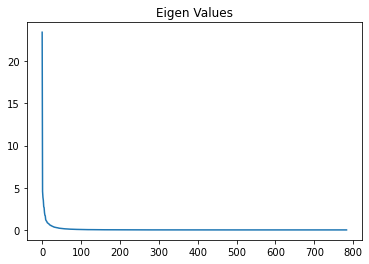

C:\Users\avons\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


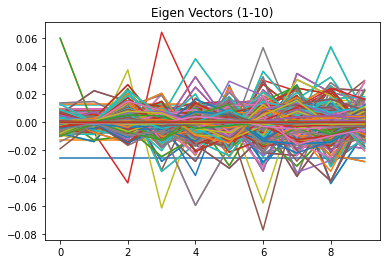

Ratio of data selected: (0.9009071274431155+0j)
Number of components selected: 53


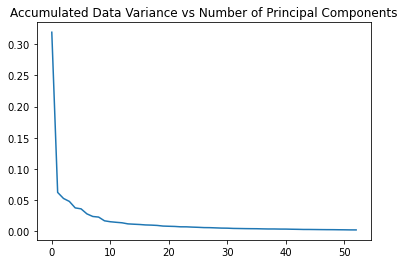

In [108]:
#Questions 2 and 3
#Question 2: Principal Component Analysis Implementation
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import SimpleITK as sitk
import torch
import torch.nn.functional as nnf
import scipy.io
import scipy.interpolate as interpolate
import math


#take in data and check whether it is processed properly for PCA
data = pd.read_csv('C://Users//avons//Downloads//PS2_Q2_mnist_for_python//mnist for python//trainX.csv', header=None)
A = np.array(data)

#(train_X, train_y), (test_X, test_y) = mnist.load_data()
#print(A)
def PCA(A): #input is a data matrix of images where each row is an image of vector form
    mean_A = A.mean() #calculate rows mean not column means
    A_mat_mean = np.full((len(A),len(A[1,:])),mean_A)
    A_bar = A - A_mat_mean
    cov_matrix = A_bar.T.dot(A_bar)/(len(A) - 1)
    w,v = np.linalg.eig(cov_matrix)
    #print(w)
    eigen_vals = w
    #print("Eigen values: ", eigen_vals)
    plt.plot(eigen_vals) #plot eigenvalues
    print(v)
    plt.title("Eigen Values")
    plt.show()
    plt.plot(v[0:10])#plot vectors
    plt.title("Eigen Vectors (1-10)")
    plt.show()
    #method to sum lambdas to see what ratio to give us about 90% of all of the data
    ratio = 0.0
    k = 0
    eig_val_sum = sum(eigen_vals)
    PCA_list = []
    while ratio <= 0.90:
        ratio += (eigen_vals[k]/eig_val_sum)
        PCA_list.append(eigen_vals[k]/eig_val_sum)
        k = k + 1
    
    plt.plot(range(k),PCA_list)
    plt.title("Accumulated Data Variance vs Number of Principal Components")
    #select the correct number of eigenvectors
    print("Ratio of data selected:", ratio)
    print("Number of components selected:", k)
    U_components = v[:,0:k]
    A_tilde = A_bar.dot(U_components) #this is our projected data - essentially our generated face
    #generated_face = Image.fromarray(A_tilde,'RGB')
    #generated_face.show()

#Call PCA on dataset
PCA(A)


torch.Size([1, 1, 1, 100, 100])


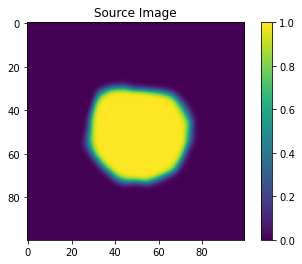

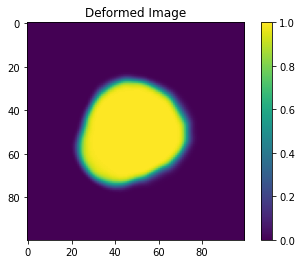

<ipython-input-100-453dfee2369c>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi0 = torch.tensor(phi0)
<ipython-input-100-453dfee2369c>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Phi1 = torch.tensor(compute_the_transformation(src,Vt))
<ipython-input-100-453dfee2369c>:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  displacement = torch.abs(torch.tensor(Phi1 - Phi_0))


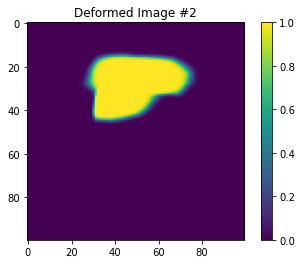

In [100]:
#Question 3
#the purpose of interpolation is to actually deform the image - it is the phi function
#can use matchgrid to create source image matrixm
def torchinterp(size, src, flow):
    vectors = [torch.arange(0, s) for s in size]
    grids = torch.meshgrid(vectors)
    grid = torch.cat((grids[2], grids[1], grids[0]), dim=0)
    grid = torch.unsqueeze(grid, 0)
    grid = torch.unsqueeze(grid, 2)
    grid = grid.type(torch.FloatTensor)
    mode='bilinear'
    # new locations
    ''' Deformation = Identity transformation + displacement field'''
    new_locs =  grid + flow
    shape = flow.shape[2:]
    # normalize deformation grid values to [-1, 1] 
    for i in range(len(shape)):
        if (i == 0) or (i == 1):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[len(shape)-i-1] - 1) - 0.5)
        if (i == 2):
            new_locs[:, 2,:,:,:] = 0
    # move channels dim to last position
    if len(shape) == 2:
        new_locs = new_locs.permute(0, 2, 3, 1)
        new_locs = new_locs[..., [1, 0]]
    elif len(shape) == 3:
        new_locs = new_locs.permute(0, 2, 3, 4, 1)
    return nnf.grid_sample(src, new_locs, mode=mode, align_corners=True)



######!!!! Loading a displacemnet field instead of phi directly!!! displacement field = Phi_1 - Phi_0 ###############
itkimage = sitk.ReadImage('C://Users//avons//Downloads//Example (1)//displace.mhd')
disp = torch.tensor(sitk.GetArrayFromImage(itkimage))
disp  = disp .permute(0, 3, 1, 2)
displace = disp.reshape(1,3,1,100,100)

######Loading a source image ###############
itkimage = sitk.ReadImage('C://Users//avons//Downloads//Example (1)//Image_3.mhd')
src= sitk.GetArrayFromImage(itkimage)
src= torch.tensor(src)
src = src.reshape(1,1,1,100,100)
size = [1,100,100]
deformed = torchinterp(size,src,displace)

print(src.shape)
######### Showing source ################
im_s = src.reshape(100,100).detach().numpy()
plt.figure()
plt.imshow(im_s)
plt.title("Source Image")
plt.colorbar()

######### Showing deformed ################
deformedim = deformed.reshape(100,100).detach().numpy()
plt.figure()
plt.imshow(deformedim)
plt.title("Deformed Image")
plt.colorbar()
plt.show()

#Creating Deformation
def dvt_dt(Vt):   #<-- reread lecture to see what goes in here
    return (np.einsum('ijkl...,...lkjm->...im', np.gradient(Vt,axis=0).T, Vt) + (np.einsum('ijkl...,...lkjm->...im',Vt,Vt.T)).T)
    #returns a 2x2 matrix

velocity = sitk.GetArrayFromImage(sitk.ReadImage('C://Users//avons//Downloads//PS2//PS2//code+data_Q3//data//initialV//v0Spatial.mhd'))
source= sitk.GetArrayFromImage(sitk.ReadImage('C://Users//avons//Downloads//PS2//PS2//code+data_Q3//data//sourceImage//source.mhd'))
velocity = np.delete(velocity,2,3)

#print("VELOCITY: ", velocity)

#print("TEMP: ",temp)
# print("SOURCE: ", source)


#create Phi_0
i,j,k=size
i_cordinates, j_cordinates, k_cordinates = np.meshgrid(range(i),range(j),range(k),indexing='ij')
Phi_0 = np.array([i_cordinates,j_cordinates,k_cordinates])
# print("This is src image dim ", src.ndim)
# print("This is Phi_0", Phi_0)

def compute_the_transformation(phi0,Vt):
    #apply phi transform to velocity
#     print("This is phi0 shape", phi0.shape)
#     print("This is Vt shape", Vt.shape)
    phi0 = torch.tensor(phi0)
    Vt = torch.squeeze(Vt)
    disp = 0.1*torch.abs(torch.einsum('ijk,lmnop->lmnop', Vt, phi0))
    disp = disp.reshape(1,1,1,100,100)
    phi1 = phi0 + disp
    #,( 0.1*(dvt_dt(Vt)))
    return phi1

#Phi1 = compute_the_transformation(src,velocity)

#   integration between V and Phi
V_x = velocity[:,:,:,0]
V_x = torch.tensor(V_x)
V_x = V_x.double()
V_x = V_x.reshape(1,1,1,100,100)

V_y = velocity[:,:,:,1]
V_y = torch.tensor(V_y)
V_y = V_y.double()
V_y = V_y.reshape(1,1,1,100,100)
Phi_0 = Phi_0.reshape(1,3,1,100,100)
# print("V_x: " , V_x.shape)
# print("V_y: ", V_y.shape)
# print("Phi_0: ", Phi_0.shape)
#print(dim1)

#displacement = displacement.reshape(1,100,100,3)

# size = torch.tensor(size)

dim1 =  torch.abs(torchinterp(size, V_x, Phi_0))
dim2 =  torchinterp(size, V_y, Phi_0)
Vt = (torch.stack([dim1,dim2]))
#print("Vt SHAPE actual: ", Vt.shape)
condition_phi_vt = dvt_dt(Vt)
#print("This is dvt_dt on Vt SHAPE: ", condition_phi_vt.shape)
Phi1 = torch.tensor(compute_the_transformation(src,Vt))
#print("This is Phi1: ", Phi1)
Phi1 = torch.squeeze(Phi1)
#print("Phi1 shape: ", Phi1.shape)
Phi1 = Phi1.reshape(1,1,1,100,100)
displacement = torch.abs(torch.tensor(Phi1 - Phi_0))
displacement = displacement.double()
src = src.double()

#print("Displacement shape: ", displacement.shape)
#print("V_x Dtype: ", V_x.dtype)
# print(Phi1)

#showing 2nd deformed
transform_deform = torchinterp(size,src,displacement)
#print("Transform Deform Shape: ", transform_deform.shape)
img_deformed = transform_deform.reshape(100,100).detach().numpy()
#print("Image Deformed Shape: ", img_deformed)
plt.figure()
plt.imshow(img_deformed)
plt.title("Deformed Image #2")
plt.colorbar()
plt.show()




# phi_arr = []
# phi_arr[0] = Vt[0]
# Euler integration part
# for i in range(len(Vt)):
#     phi_arr[i+1] =  phi_arr[i] + h*[Vt[i] "circle phi_i"  ] phi_t 
    
 #deformed_euler = torchinterp(size, src, Phi_1 - Phi_0)
        
# #take the euler integral of transformed image and convert it back to image
# .
# #E(Phi) --> deformed image
# #D is the jacobian function
# """
# Using my code to deform an image: interp (size, Source, Phi_1 - Phi_0)

# Using my code to do the integration between V and Phi, interp (size, V_x, Phi_t- Phi0) interp (size, V_y, Phi_t- Phi0)

# """

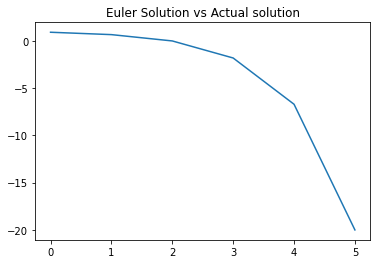

In [138]:
"""
Use this to plot the ODE, does not work on my machine
from scipy.integrate import odeint
def fknot(t,y_prev):
    return (2 - (math.e**t) - 2(y_prev))

#h = 0.1
m = 1
t = np.linspace(0,5)
N = odeint(fknot,m,t)
plt.plot(t,N)""" 
# val_list = [] 
# for i in range(5):
#     if i == 0:
#         val_list.append(-1)
#     else:
#         prev = val_list[-1]
#         val_list.append(fknot(i,prev))
plt.plot([0,1,2,3,4,5],[0.9,0.64817,-0.02036,-1.82484,-6.71968,-20.01705])
#plt.plot([0,1,2,3,4,5],val_list)
plt.title("Euler Solution vs Actual solution")
plt.show()

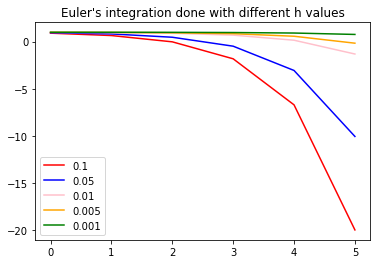

In [116]:
plt.figure()
plt.plot([0,1,2,3,4,5],[0.9,0.64817,-0.02036,-1.82484,-6.71968,-20.01705], color = 'red', label="0.1")
plt.plot([0,1,2,3,4,5],[0.95,0.81908,0.46771,-0.48333,-3.06490,-10.079067], color='blue', label="0.05")
plt.plot([0,1,2,3,4,5],[0.99,0.96301,0.88985,0.69119,0.15138,-1.31577], color='pink', label = "0.01")
plt.plot([0,1,2,3,4,5],[0.995,0.981458,0.94469,0.84481,0.57337,-0.16442], color='orange', label = "0.005")
plt.plot([0,1,2,3,4,5],[0.999,0.99628,0.98889,0.96882,0.91428,0.76603], color='green', label = "0.001")
plt.legend()
plt.title("Euler's integration done with different h values")
plt.show()